<a href="https://colab.research.google.com/github/lydian/CatFaceDetection/blob/master/deep_learning_cat_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess Video 


In [0]:
video_path = "/content/drive/My Drive/motion/litter_robot/"
output_image_folder = "/content/drive/My Drive/cat/to_label/"
LABELS = {val: id for id, val in enumerate(["boba", "hojicha", "both", "rotate", "other"])}
labeled_folder = "/content/drive/My Drive/cat/labeled/"


##  Parse images from video
1. parse image from video. (Note that I shrink the image to 300 * 300, otherwise i probably don't have enough space on my google drive to store the original data. This is probably okay for image recognition) 
2. send the parsed image to classifier to find cat 

In [0]:
!pip install opencv-python tqdm
# Make folder to store the images
!mkdir -p images

In [0]:
import cv2
import os
from tqdm.notebook import tqdm


def video_to_frames(input_path, output_folder, output_prefix, output_size=300, frame_rate=0.5, start=0):
    cap = cv2.VideoCapture(input_path)
    fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if fps <= 0: 
        logging.warning(f"Failed to parse {input_path}, fps = {fps}")
        return
    for count in range(0, int(frame_count // (frame_rate * fps))):
        sec  = round(count * frame_rate, 2) * 1000 
        cap.set(cv2.CAP_PROP_POS_MSEC, sec)
        success, image = cap.read()
        if not success:
            break

        # crop to make it square
        w, h = image.shape[:2]
        size = min(w, h) // 2
        image = image[w//2-size: w//2 + size, h//2-size:h//2+size]

        output_path = os.path.join(output_folder, f"{output_prefix}_{count}.jpg")
        # shrink to 300 * 300 (we don't really need large picture)
        image = cv2.resize(image, (output_size, output_size))
        # save frame as JPG file
        cv2.imwrite(output_path, image)     
    
    #print(f"Video {video_path} Caputred {count} frames\r")


def parse_videos(input_folder, output_folder, output_size=300, frame_rate=0.5, start=0):
    if not os.path.exists(output_folder):
        os.makedirs(output)
    files = [
        os.path.join(root, file_name)
        for root, _, files in os.walk(input_folder)
        for file_name in files
        if file_name.endswith(".mp4")
    ]

    for input_path in tqdm(files):        
        # the input video has name in `yyyy-mm-dd/hh-MM-ss.mp4` 
        output_prefix = input_path.replace(input_folder, "").replace("-", "").replace("/", "-").rsplit(".", 1)[0]
        if os.path.exists(output_prefix + "_0.jpg"):
            logging.info(f"skip {input_path}, file_exists")
            continue
        
        video_to_frames(
            input_path,
            output_folder,
            output_prefix,
            output_size=output_size, 
            frame_rate=frame_rate, 
            start=start
        )


parse_videos(video_path, output_folder=output_image_folder, frame_rate=10.0)

# Label session 



In [0]:
!pip install ipywidgets

2409
[('rotate', 680), ('hojicha', 374), ('boba', 204), ('other', 176)]


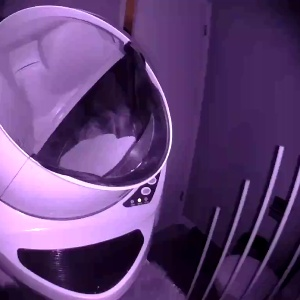

'/content/drive/My Drive/cat/to_label/20200520-013403_0.jpg'

In [0]:
import os
import functools

import ipywidgets as widgets
from IPython.core.display import Image, display, clear_output

def on_label(_, label, path):
    print(label, path)
    target = os.path.join(labeled_folder, label)
    if not os.path.exists(target):
        os.makedirs(target)
    base_name = os.path.basename(path)
    os.rename(path, os.path.join(target, base_name))
    clear_output()
    show_next()
    

def show_example(current_path):
    buttons = []
    for label in LABELS:
        button = widgets.Button(description=label)
        button.on_click(functools.partial(on_label, label=label, path=current_path))
        buttons.append(button)

    display(Image(filename=current_path))
    display(current_path)
    display(widgets.HBox(buttons))


def get_label_result():
    labeled_count = {
        label: len(os.listdir(os.path.join(labeled_folder, label)))
        for label in LABELS
        if os.path.exists(os.path.join(labeled_folder, label))
    }
    return sorted(labeled_count.items(), key=lambda x: -x[1])

           
def show_next():
    files = os.listdir(output_image_folder)
    print(len(files))
    print(get_label_result())
    if files:
        current_path = os.path.join(output_image_folder, files[0])
        show_example(current_path)
    else:
        print("All labeled")

show_next()

# Modeling


## Prepare Data

In [0]:
import os 

import numpy as np
import tensorflow as tf
import pathlib

LABELS = {val: id for id, val in enumerate(["boba", "hojicha", "both", "rotate", "other"])}

labeled_folder = "/content/drive/My Drive/cat/labeled/"
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
train = data_gen.flow_from_directory(
    labeled_folder,
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=32,
    subset="training"
)
validation = data_gen.flow_from_directory(
    labeled_folder,
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=32,
    subset="validation"
)

Found 1149 images belonging to 4 classes.
Found 285 images belonging to 4 classes.


## Build Model

In [0]:
import random

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D

import numpy as np

base_model = Xception(
    input_shape=(300, 300, 3),
    weights='imagenet', include_top=False)  # do not include the Fully connected layer
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have  classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

83689472/83683744 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [0]:
# train the model on the new data for a few epochs
history = model.fit(
    train,
    epochs=20,
    steps_per_epoch=train.samples / train.batch_size,
    validation_data=validation
)

Epoch 1/20
36/35 [==============================] - 792s 22s/step - loss: 0.5397 - accuracy: 0.8120 - val_loss: 0.2077 - val_accuracy: 0.9263
Epoch 2/20
36/35 [==============================] - 7s 195ms/step - loss: 0.1840 - accuracy: 0.9347 - val_loss: 0.3016 - val_accuracy: 0.9053
Epoch 3/20
36/35 [==============================] - 7s 191ms/step - loss: 0.1521 - accuracy: 0.9408 - val_loss: 0.1617 - val_accuracy: 0.9474
Epoch 4/20
36/35 [==============================] - 7s 192ms/step - loss: 0.0910 - accuracy: 0.9730 - val_loss: 0.1266 - val_accuracy: 0.9474
Epoch 5/20
36/35 [==============================] - 7s 191ms/step - loss: 0.0814 - accuracy: 0.9739 - val_loss: 0.1542 - val_accuracy: 0.9333
Epoch 6/20
36/35 [==============================] - 7s 192ms/step - loss: 0.0606 - accuracy: 0.9809 - val_loss: 0.1153 - val_accuracy: 0.9579
Epoch 7/20
36/35 [==============================] - 7s 194ms/step - loss: 0.0645 - accuracy: 0.9774 - val_loss: 0.1189 - val_accuracy: 0.9614
Epoch 

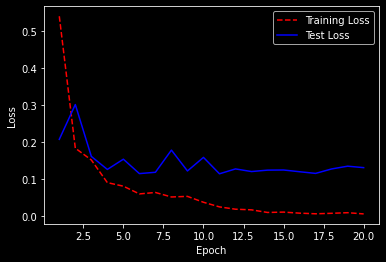

In [0]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Prediction


{'boba': 0, 'hojicha': 1, 'other': 2, 'rotate': 3} {'boba': 0, 'hojicha': 1, 'other': 2, 'rotate': 3}


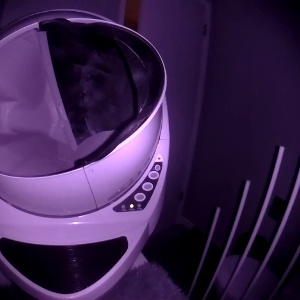

[[2.3267802e-07 1.1736161e-09 7.0297745e-07 9.9999905e-01]] 3
label: rotate
Predicted: rotate


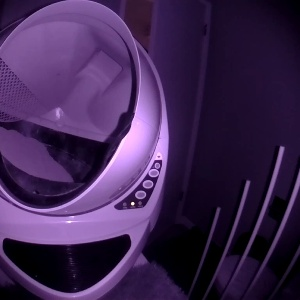

[[2.8743854e-05 8.9911322e-07 1.7912815e-06 9.9996853e-01]] 3
label: rotate
Predicted: rotate


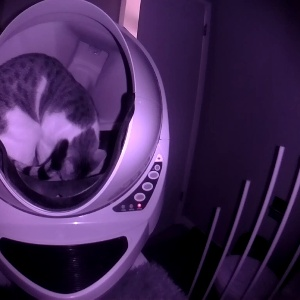

[[9.9410629e-01 5.8930251e-03 6.5735173e-07 2.3291031e-08]] 0
label: boba
Predicted: boba


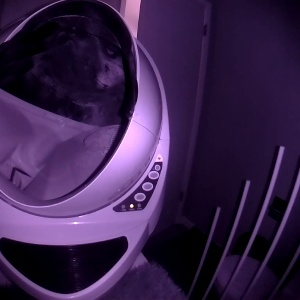

[[3.90907871e-06 1.10694245e-05 5.24034249e-06 9.99979734e-01]] 3
label: rotate
Predicted: rotate


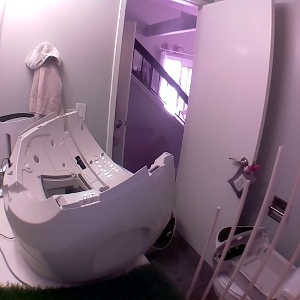

[[1.1432256e-05 5.1236721e-06 9.9998331e-01 1.3477799e-07]] 2
label: other
Predicted: other


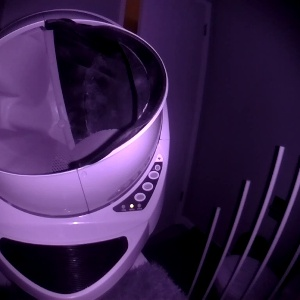

[[1.2421632e-06 5.4040350e-09 1.0179291e-06 9.9999774e-01]] 3
label: rotate
Predicted: rotate


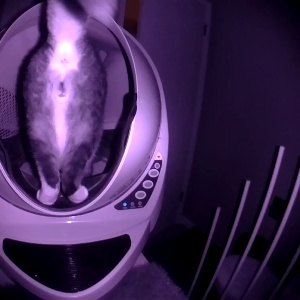

[[2.8732254e-03 9.9710947e-01 1.6961296e-05 3.6603950e-07]] 1
label: hojicha
Predicted: hojicha


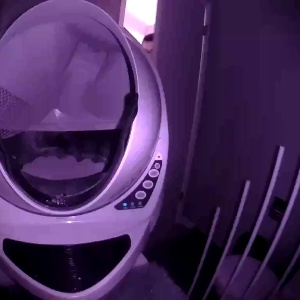

[[8.1564346e-04 1.6516968e-04 7.7773412e-03 9.9124181e-01]] 3
label: rotate
Predicted: rotate


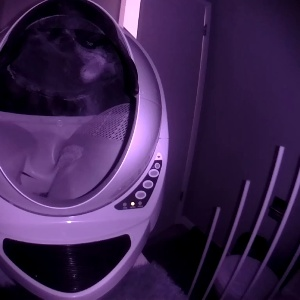

[[1.2431147e-05 3.8862658e-05 2.3283917e-05 9.9992549e-01]] 3
label: rotate
Predicted: rotate


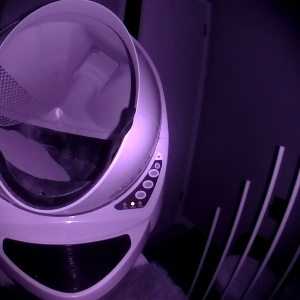

[[7.5599555e-06 8.0038154e-07 9.6210624e-07 9.9999070e-01]] 3
label: rotate
Predicted: rotate


In [0]:
from IPython.display import Image
from keras.preprocessing import image

print(train.class_indices, validation.class_indices)
predict_to_cls = {v: k for k, v in validation.class_indices.items()}
def test(size=10):

    for img_path in random.sample(validation.filepaths, size):
        display(Image(filename=img_path))
        img = image.load_img(img_path, target_size=(300, 300))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) 

        images = np.vstack([x]) / 255.
        predict = model.predict(images)
        print(predict, np.argmax(predict[0]))
        str_class = predict_to_cls[np.argmax(predict[0])]
        print("label:", img_path.rsplit("/", 2)[-2])
        print('Predicted:', str_class)


test(10)